# Mini-Project 1 : Image Classification and Regression

## Yonatan Deloro, Master MVA

## mail : yonatan.deloro@eleves.enpc.fr

## 0. Imports and code from utils.py 

(so that the ipynb is self contained)

In [147]:
#imports

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, Flatten, Reshape
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

#%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 7,7

IMAGE_SIZE = 72

In [ ]:
## On some implementations of matplotlib, you may need to change this value

def generate_a_drawing(figsize, U, V, noise=0.0, pair=False):
    #if pair=True, returns the pair of the noised image and the image without the noise
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    if pair:
        imdata0 = imdata.copy()
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    if pair:
        return imdata, imdata0
    else:
        return imdata

def generate_a_rectangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise, pair=pair)


def generate_a_disk(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise, pair=pair)

def generate_a_triangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise, pair=pair)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y, IMAGE_SIZE):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Part 1 : Simple Classification

In [6]:
[X, Y] = generate_dataset_classification(650, noise=20)
[X_train, Y_train] = [X[:300],Y[:300]]
[X_val, Y_val] = [X[300:350],Y[300:350]]
[X_test, Y_test] = [X[350:],Y[350:]]

Creating data:
Done


In [7]:
#building a linear classifier

def build_linear_classifier():
    model = Sequential()
    model.add(Dense(3, input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    model.add(Activation('softmax'))
    return model

model = build_linear_classifier()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 15555     
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizers = {
   "sgd" : SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
   "adam" : Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
}

early_stopping_monitor = EarlyStopping(patience = 5)

In [22]:
categorical_Y_train = to_categorical(Y_train)
categorical_Y_val = to_categorical(Y_val)

losses = {}
trained_models = {}

for (name_opt,opt) in optimizers.items():
    print("\nTraining the model with "+name_opt)

    model = build_linear_classifier()
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics = ["accuracy"])
    history = model.fit(X_train, categorical_Y_train, validation_data=(X_val,categorical_Y_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

    losses[name_opt]= {}
    losses[name_opt]["train"] = history.history['loss']
    losses[name_opt]["val"] = history.history['val_loss']
    
    trained_models[name_opt] = model


Training the model with sgd
Train on 300 samples, validate on 50 samples
Epoch 1/100
300/300 [==============================] - 0s 822us/step - loss: 1.0782 - acc: 0.4933 - val_loss: 1.4590 - val_acc: 0.3400
Epoch 2/100
300/300 [==============================] - 0s 69us/step - loss: 0.7557 - acc: 0.6667 - val_loss: 0.7330 - val_acc: 0.6400
Epoch 3/100
300/300 [==============================] - 0s 80us/step - loss: 0.4785 - acc: 0.8000 - val_loss: 0.4757 - val_acc: 0.8600
Epoch 4/100
300/300 [==============================] - 0s 73us/step - loss: 0.3969 - acc: 0.8167 - val_loss: 0.5190 - val_acc: 0.7200
Epoch 5/100
300/300 [==============================] - 0s 81us/step - loss: 0.3273 - acc: 0.9000 - val_loss: 0.2915 - val_acc: 0.9200
Epoch 6/100
300/300 [==============================] - 0s 95us/step - loss: 0.2755 - acc: 0.9300 - val_loss: 0.2608 - val_acc: 0.9000
Epoch 7/100
300/300 [==============================] - 0s 85us/step - loss: 0.2456 - acc: 0.9267 - val_loss: 0.2429 - val

300/300 [==============================] - 0s 74us/step - loss: 0.0256 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 1.0000
Epoch 43/100
300/300 [==============================] - 0s 88us/step - loss: 0.0228 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 1.0000
Epoch 44/100
300/300 [==============================] - 0s 72us/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 45/100
300/300 [==============================] - 0s 69us/step - loss: 0.0240 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 1.0000
Epoch 46/100
300/300 [==============================] - 0s 69us/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 1.0000
Epoch 47/100
300/300 [==============================] - 0s 74us/step - loss: 0.0216 - acc: 1.0000 - val_loss: 0.0233 - val_acc: 1.0000
Epoch 48/100
300/300 [==============================] - 0s 80us/step - loss: 0.0201 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 1.0000
Epoch 49/100
300/300 [==============================] - 0s 80us/step

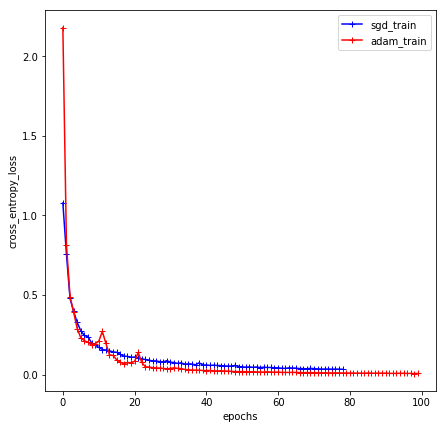

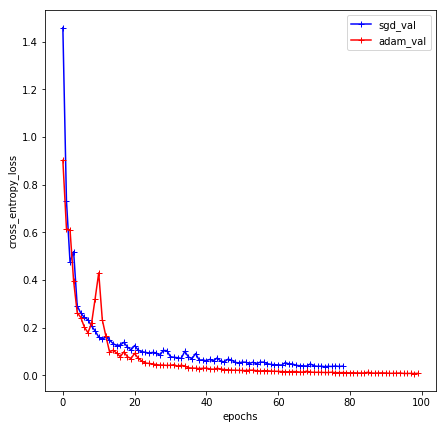

In [23]:
epochs_sgd = np.arange(len(losses['sgd']['train']))
epochs_adam = np.arange(len(losses['adam']['train']))

plt.plot(epochs_sgd,losses["sgd"]['train'],marker="+",color="b",label="sgd_train")
plt.plot(epochs_adam,losses["adam"]['train'],marker="+",color="r",label="adam_train")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

plt.plot(epochs_sgd,losses["sgd"]['val'],marker="+",color="b",label="sgd_val")
plt.plot(epochs_adam,losses["adam"]['val'],marker="+",color="r",label="adam_val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

In [24]:
categorical_Y_test = to_categorical(Y_test)
res = trained_models["sgd"].evaluate(X_test, categorical_Y_test)
print("SGD optimizer.\ncross-entropy loss, accurracy score : \n",res,"\n")

res = trained_models["adam"].evaluate(X_test, categorical_Y_test)
print("Adam optimizer.\ncross-entropy loss, accurracy score : \n",res)

300/300 [==============================] - 0s 40us/step
SGD optimizer.
cross-entropy loss, accurracy score : 
 [0.0667786870400111, 0.9833333333333333] 

300/300 [==============================] - 0s 41us/step
Adam optimizer.
cross-entropy loss, accurracy score : 
 [0.02029029873510202, 0.9933333333333333]


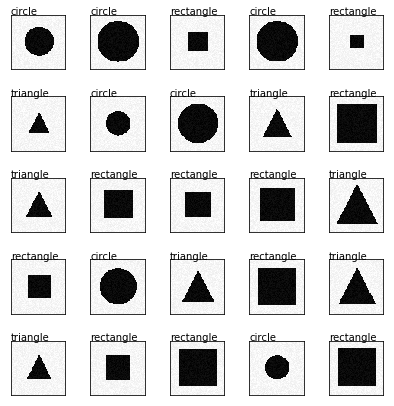

In [25]:
#plotting some data and their predictions

name_labels = ["rectangle","circle", "triangle"]

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for (idx,k) in enumerate(np.random.choice(X_test.shape[0],25)):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_test[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    predicted_Y = model.predict(X_test[k][None,:])
    label = name_labels[np.argmax(predicted_Y)]
    ax[i,j].text(-0.5,-0.5,label,fontsize=10)

plt.show()

# Part 2 - Visualization of the Solution

Weights of the three columns of the weights


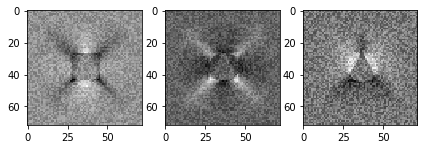

In [33]:
#visualizing the weights of the three neurons

model = trained_models["adam"]
W = model.get_weights()[0] #only focus on W (not intercept)

print("Weights of the three columns of the weights")
for col in range(W.shape[1]):
    plt.subplot(eval("13"+str(col+1)))
    plt.imshow(W[:,col].reshape((IMAGE_SIZE,IMAGE_SIZE)), cmap='gray')
plt.show()


# Part 3 - A More Difficult Classification Problem

## a)  a linear classifier can"t learn the classification frontiers

In [95]:
N_train = 2000 ; N_val = 100 
N_total = N_train + N_val

[X, Y] = generate_dataset_classification(N_total, noise=20, free_location=True)
[X_train, Y_train] = [X[:N_train],Y[:N_train]]
[X_val, Y_val] = [X[N_train:],Y[N_train:]]

[X_test, Y_test] =  generate_test_set_classification()

categorical_Y_train = to_categorical(Y_train)
categorical_Y_val = to_categorical(Y_val)
categorical_Y_test = Y_test #Y_test already categorical

Creating data:
Done
Creating data:
Done


In [103]:
model = build_linear_classifier()
model.compile(loss='categorical_crossentropy',optimizer=optimizers["adam"], metrics = ["accuracy"])
history = model.fit(X_train, categorical_Y_train, validation_data=(X_val,categorical_Y_val), epochs=30, callbacks=[early_stopping_monitor], batch_size=32)

Train on 2000 samples, validate on 100 samples
Epoch 1/30
2000/2000 [==============================] - 1s 341us/step - loss: 6.0471 - acc: 0.4290 - val_loss: 6.1725 - val_acc: 0.3100
Epoch 2/30
2000/2000 [==============================] - 0s 61us/step - loss: 5.7790 - acc: 0.5050 - val_loss: 5.7047 - val_acc: 0.5100
Epoch 3/30
2000/2000 [==============================] - 0s 68us/step - loss: 5.6441 - acc: 0.5430 - val_loss: 5.8888 - val_acc: 0.3200
Epoch 4/30
2000/2000 [==============================] - 0s 63us/step - loss: 5.6065 - acc: 0.5405 - val_loss: 5.6363 - val_acc: 0.5000
Epoch 5/30
2000/2000 [==============================] - 0s 65us/step - loss: 5.5854 - acc: 0.5550 - val_loss: 5.7420 - val_acc: 0.4800
Epoch 6/30
2000/2000 [==============================] - 0s 64us/step - loss: 5.6328 - acc: 0.5375 - val_loss: 5.6653 - val_acc: 0.5400
Epoch 7/30
2000/2000 [==============================] - 0s 61us/step - loss: 5.5782 - acc: 0.5550 - val_loss: 5.6286 - val_acc: 0.5200
Epoch 8

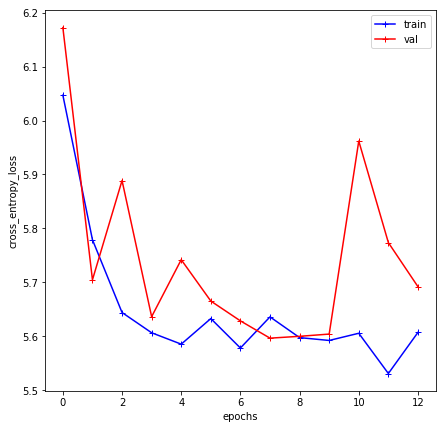

In [104]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

In [106]:
res = model.evaluate(X_test, categorical_Y_test)
print("SGD optimizer.\ncross-entropy loss, accurracy score : \n",res,"\n")

300/300 [==============================] - 0s 48us/step
SGD optimizer.
cross-entropy loss, accurracy score : 
 [5.5619825236002605, 0.563333332935969] 



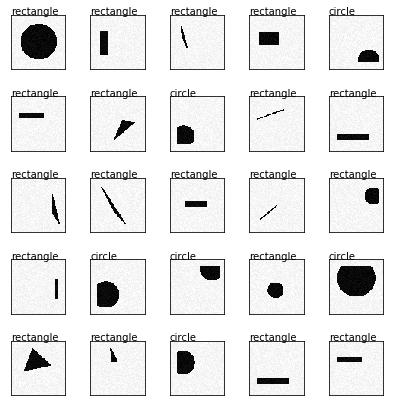

In [107]:
#plotting some data and their predictions

name_labels = ["rectangle","circle", "triangle"]

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

selection = np.random.choice(X_test.shape[0],25)
for (idx,k) in enumerate(selection):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_test[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    predicted_Y = model.predict(X_test[k][None,:])
    label = name_labels[np.argmax(predicted_Y)]
    ax[i,j].text(-0.5,-0.5,label,fontsize=10)

plt.show()

## b)  let us build a simple convolutional network

In [78]:
def build_convolutional_network():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model

In [79]:
def reshape_as_images(X):
    nb_samples = X.shape[0]
    X2 = np.zeros((nb_samples,IMAGE_SIZE,IMAGE_SIZE,1))
    for k in range(nb_samples):
        X2[k,:] = np.reshape(X[k,:],(IMAGE_SIZE,IMAGE_SIZE,1))
    return X2

In [90]:
print(X_train.shape)
X_train = reshape_as_images(X_train)
print(X_train.shape)

X_val = reshape_as_images(X_val)
X_test = reshape_as_images(X_test)

(2000, 5184)
(2000, 72, 72, 1)


In [82]:
model = build_convolutional_network()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=optimizers["adam"], metrics = ["accuracy"])
history = model.fit(X_train, categorical_Y_train, validation_data=(X_val,categorical_Y_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 55491     
_________________________________________________________________
activation_21 (Activation)   (None, 3)                 0         
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 100 samples
Epoch 1/100
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0485 - acc: 

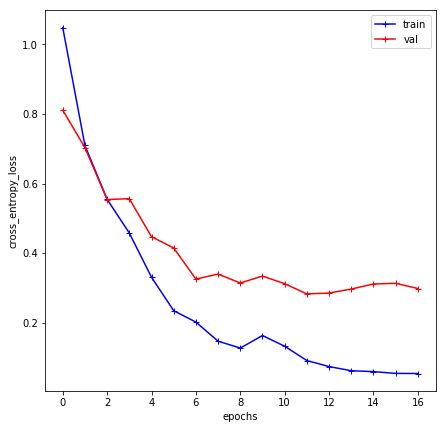

In [93]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.show()

In [91]:
res = model.evaluate(X_test, categorical_Y_test)
print("SGD optimizer.\ncross-entropy loss, accurracy score : \n",res,"\n")

300/300 [==============================] - 0s 649us/step
SGD optimizer.
cross-entropy loss, accurracy score : 
 [0.19805786728858948, 0.9399999992052714] 



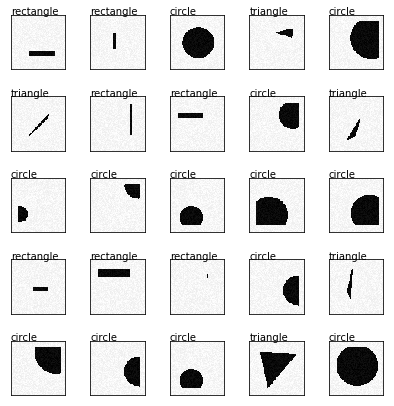

In [92]:
#plotting some data and their predictions

name_labels = ["rectangle","circle", "triangle"]

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for (idx,k) in enumerate(selection):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_test[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    predicted_Y = model.predict(X_test[k][None,:])
    label = name_labels[np.argmax(predicted_Y)]
    ax[i,j].text(-0.5,-0.5,label,fontsize=10)

plt.show()

# Part 4 - A Regression Problem

In [108]:
N_train = 2000 ; N_val = 100
N_total = N_train + N_val

[X, Y] = generate_dataset_regression(N_total, noise=20)
[X_train, Y_train] = [X[:N_train],Y[:N_train]]
[X_val, Y_val] = [X[N_train:],Y[N_train:]]

[X_test, Y_test] = generate_test_set_regression()

Creating data:
Done
Creating data:
Done


In [109]:
X_train = reshape_as_images(X_train)
X_val = reshape_as_images(X_val)
X_test = reshape_as_images(X_test)

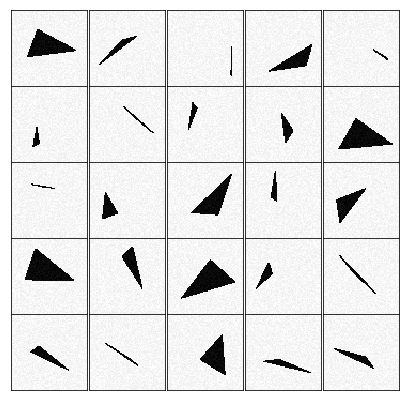

In [112]:
#visualizing some images of the dataset

fig, ax = plt.subplots(5, 5, figsize=(7, 7))
fig.subplots_adjust(hspace=0., wspace=0.)

for (idx,k) in enumerate(np.random.choice(X_test.shape[0],25)):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    ax[i, j].imshow(X_train[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.show()

In [115]:
def normalize(Y):
    
    #sort vertices by distances to origin
    
    Z = np.zeros((Y.shape[0],6))
    
    r0A = Y[:,0]*Y[:,0] + Y[:,1]*Y[:,1]
    r0B = Y[:,2]*Y[:,2] + Y[:,3]*Y[:,3]
    r0C = Y[:,4]*Y[:,4] + Y[:,5]*Y[:,5]
    
    M = np.argsort(np.array([r0A,r0B,r0C]).T,axis=1)
            
    for k in range(M.shape[0]):
        Z[k,0] = Y[k,2*M[k,0]] #abciss vertex with lowest distance to G
        Z[k,1] = Y[k,2*M[k,0]+1]  
        Z[k,2] = Y[k,2*M[k,1]]
        Z[k,3] = Y[k,2*M[k,1]+1]
        Z[k,4] = Y[k,2*M[k,2]]
        Z[k,5] = Y[k,2*M[k,2]+1]
    
    return Z

In [116]:
Z_train = normalize(Y_train)
Z_val = normalize(Y_val)
Z_test = normalize(Y_test)

In [117]:
def build_regressor():
    
    model = Sequential()
    
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.3))
    
    model.add(Flatten())    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6))
    
    return model

In [118]:
model = build_regressor()
model.summary()

model.compile(loss='mean_squared_error',optimizer=optimizers['adam'], metrics = ["accuracy"])
history = model.fit(X_train, Z_train, validation_data=(X_val,Z_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 16)        6416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 16)          0         
__________

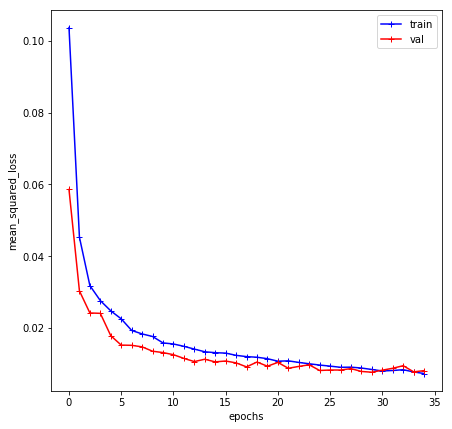

300/300 [==============================] - 0s 1ms/step
SGD optimizer.
mean-squared loss : [0.012827173421780268, 0.7933333333333333] 



In [119]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("mean_squared_loss") ; plt.legend()
plt.show()

res = model.evaluate(X_test, Z_test)
print("SGD optimizer.\nmean-squared loss :",res,"\n")

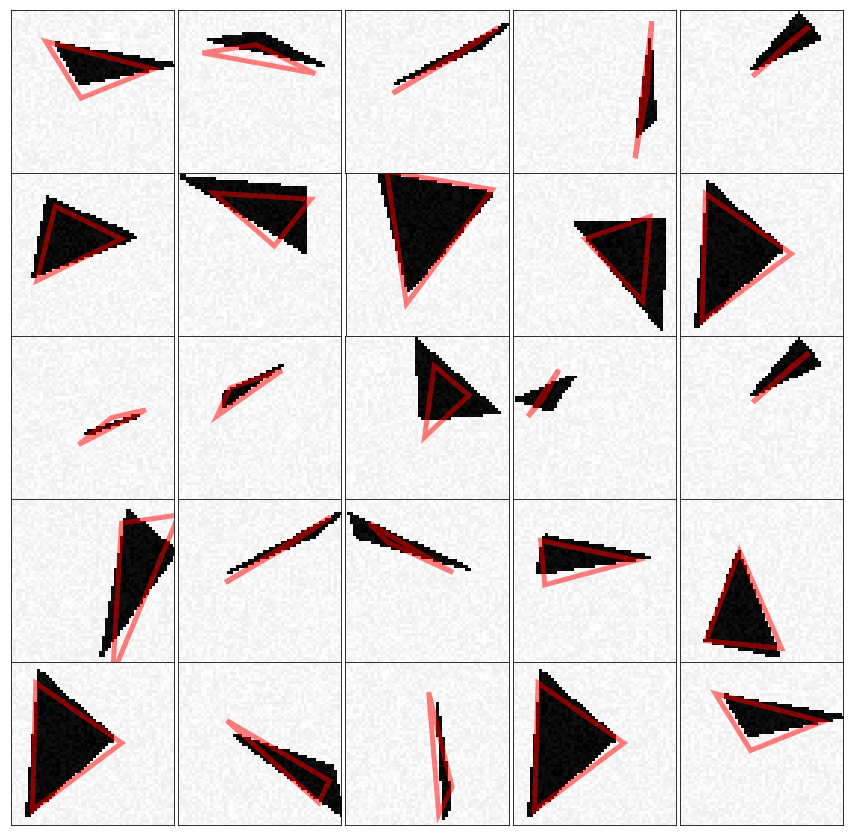

In [120]:
def visualize_prediction(x, y, IMAGE_SIZE, ax):
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace=0., wspace=0.)

selection = np.random.choice(X_test.shape[0],25)
for (idx,k) in enumerate(selection):
    i = idx%5; j = idx//5
    ax[i, j].xaxis.set_major_locator(plt.NullLocator())
    ax[i, j].yaxis.set_major_locator(plt.NullLocator())
    x = X_test[k,:]
    y = model.predict(x[None,:,:,:])
    visualize_prediction(x, y, IMAGE_SIZE, ax[i, j])
    
plt.show()    

## another normalization

In [123]:
from math import pi

def normalize_2(Y):
    
    Z = np.zeros((Y.shape[0],6))
    Z[:,0] = (Y[:,0] + Y[:,2] + Y[:,4])/3.  #barycenter
    Z[:,1] = (Y[:,1] + Y[:,3] + Y[:,5])/3.
    
    xGA = Y[:,0] - Z[:,0] 
    yGA = Y[:,1] - Z[:,1]
    xGB = Y[:,2] - Z[:,0] 
    yGB = Y[:,3] - Z[:,1]
    xGC = Y[:,4] - Z[:,0] 
    yGC = Y[:,5] - Z[:,1]
    
    r0 = yGA/xGA
    r1 = yGB/xGB
    r2 = yGC/xGC
    
    alpha = np.arctan(r0) + pi*(xGA<0) + 2*pi*((xGA>0)*(yGA<0))  #angle between xA-xG and x-axis        
    beta = np.arctan(r1) + pi*(xGB<0) + 2*pi*((xGB>0)*(yGB<0)) #angle between xB-xG and x-axis
    gamma = np.arctan(r2) + pi*(xGC<0)+ 2*pi*((xGC>0)*(yGC<0)) #angle between xC-xG and x-axis 
    M = np.argsort(np.array([alpha,beta,gamma]).T,axis=1)
    
    for k in range(M.shape[0]):
        Z[k,0] = Y[k,2*M[k,0]] #abciss vertex with lowest angle
        Z[k,1] = Y[k,2*M[k,0]+1]  
        Z[k,2] = Y[k,2*M[k,1]]
        Z[k,3] = Y[k,2*M[k,1]+1]
        Z[k,4] = Y[k,2*M[k,2]]
        Z[k,5] = Y[k,2*M[k,2]+1]
    
    return Z

In [124]:
Z_train = normalize_2(Y_train)
Z_val = normalize_2(Y_val)
Z_test = normalize_2(Y_test)

model = build_regressor()
model.summary()

model.compile(loss='mean_squared_error',optimizer=optimizers['adam'], metrics = ["accuracy"])
history = model.fit(X_train, Z_train, validation_data=(X_val,Z_val), epochs=10, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 16)        6416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 16)          0         
__________

# Part 5 -  Image Denoising

In [165]:
def generate_dataset_denoising(nb_samples, max_noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = max_noise*np.random.rand()
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location, pair=True)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location, pair=True)
        else:
            X[i], Y[i] = generate_a_triangle(noise, free_location, pair=True)[0]
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]


def generate_test_set_denoising(max_noise=0.0):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, max_noise=max_noise, free_location=True)
    return [X_test, Y_test]

In [180]:
max_noise = 100

N_train = 300 ; N_val = 100
N_total = N_train + N_val

[X, Y] = generate_dataset_denoising(N_total, max_noise=max_noise, free_location=True)
[X_train, Y_train] = [X[:N_train],Y[:N_train]]
[X_val, Y_val] = [X[N_train:],Y[N_train:]]

[X_test, Y_test] = generate_test_set_denoising(max_noise=max_noise)

Creating data:
Done
Creating data:
Done


Noised image (left) and without noise (right)


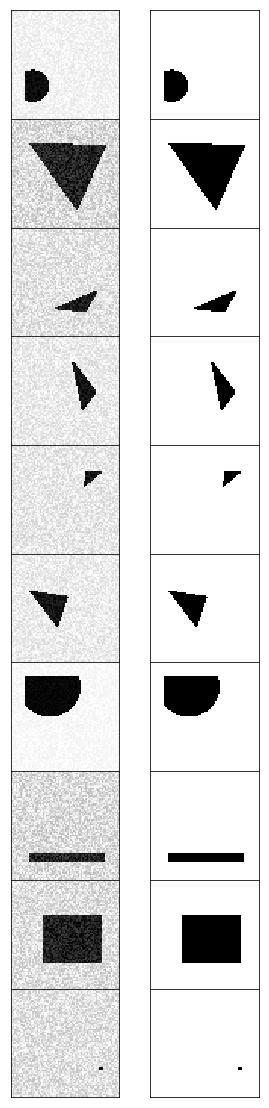

In [181]:
#visualizing some images of the dataset

print("Noised image (left) and without noise (right)")

fig, ax = plt.subplots(10, 2, figsize=(5, 20))
fig.subplots_adjust(hspace=0., wspace=0.)

for (i,k) in enumerate(np.random.choice(X_train.shape[0],10)):
    
    ax[i, 0].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].imshow(X_train[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
            
    ax[i, 1].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].imshow(Y_train[k].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.show()

In [182]:
X_train = reshape_as_images(X_train)
Y_train = reshape_as_images(Y_train)

X_val = reshape_as_images(X_val)
Y_val = reshape_as_images(Y_val)

X_test = reshape_as_images(X_test)
Y_test = reshape_as_images(X_test)

In [183]:
def build_hourglass_network():
    
    model = Sequential()
    
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2DTranspose(16, (5, 5), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(16, (5, 5), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(16, (5, 5), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Dense(1))
    
    return model

In [184]:
model = build_hourglass_network()
model.summary()
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=100, callbacks=[early_stopping_monitor], batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 36, 36, 16)        6416      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 18, 18, 16)        6416      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 9, 9, 16)          6416      
__________

300/300 [==============================] - 3s 10ms/step - loss: 1047.8719 - val_loss: 1133.3688
Epoch 58/100
300/300 [==============================] - 3s 11ms/step - loss: 1064.8177 - val_loss: 1069.5676
Epoch 59/100
300/300 [==============================] - 3s 9ms/step - loss: 1047.6182 - val_loss: 1056.5786
Epoch 60/100
300/300 [==============================] - 3s 9ms/step - loss: 1017.7203 - val_loss: 1052.0650
Epoch 61/100
300/300 [==============================] - 3s 9ms/step - loss: 1004.6269 - val_loss: 1038.1344
Epoch 62/100
300/300 [==============================] - 3s 11ms/step - loss: 999.0045 - val_loss: 1050.1307
Epoch 63/100
300/300 [==============================] - 3s 10ms/step - loss: 999.6758 - val_loss: 1026.3541
Epoch 64/100
300/300 [==============================] - 3s 10ms/step - loss: 987.4638 - val_loss: 1076.8035
Epoch 65/100
300/300 [==============================] - 3s 9ms/step - loss: 1008.3589 - val_loss: 1012.2873
Epoch 66/100
300/300 [=================

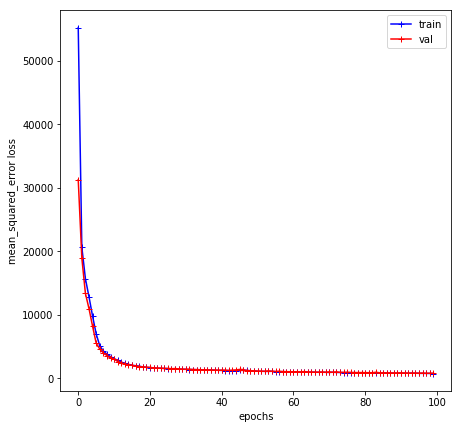

300/300 [==============================] - 1s 3ms/step
SGD optimizer.
mean_squared_error loss :  37434.39015625 



In [185]:
epochs = np.arange(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],marker="+",color="b",label="train")
plt.plot(epochs,history.history['val_loss'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("mean_squared_error loss") ; plt.legend()
plt.show()

res = model.evaluate(X_test, Y_test)
print("SGD optimizer.\nmean_squared_error loss : ",res,"\n")

Noised image (left) and denoised image (right)


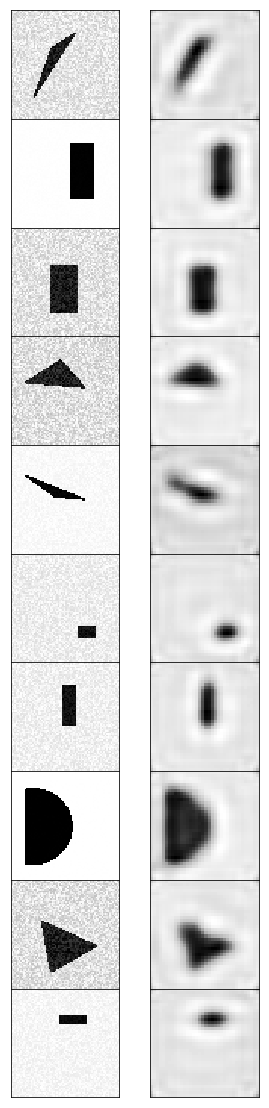

In [186]:
#Visualizing some denoised images

input_images = X_test[np.random.choice(X_test.shape[0],10)] 
denoised_images =  model.predict(input_images)

print("Noised image (left) and denoised image (right)")

fig, ax = plt.subplots(10, 2, figsize=(5, 20))
fig.subplots_adjust(hspace=0., wspace=0.)

for i in range(len(input_images)):
    
    ax[i, 0].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 0].imshow(input_images[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
        
    ax[i, 1].xaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].yaxis.set_major_locator(plt.NullLocator())
    ax[i, 1].imshow(denoised_images[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.show()